<h2>Посмотрим матрицу кореляции, разделим данные на тренировочную и обучающую выборки и обучеим модели МО</h2>

<h3>Посмотрим матрицу кореляций</h3>

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
df = pd.read_csv("cleaned_and_prepared_data_2.csv")

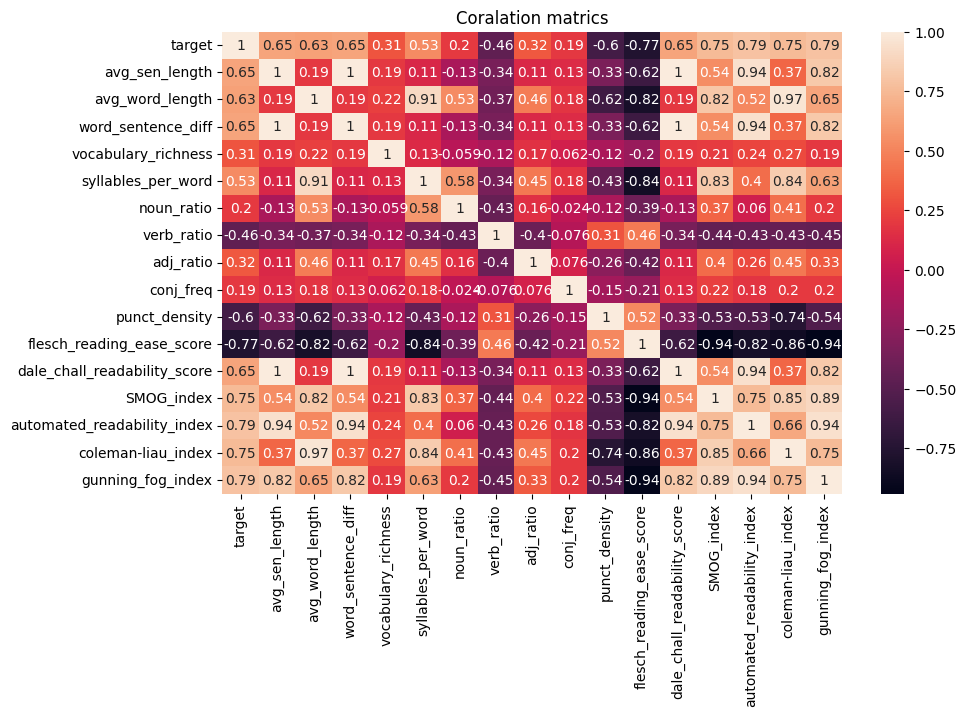

In [ ]:
df_for_corr = df[['target', 'avg_sen_length', 'avg_word_length',
       'word_sentence_diff', 'vocabulary_richness', 'syllables_per_word',
       'noun_ratio', 'verb_ratio', 'adj_ratio', 'conj_freq', 'punct_density',
       'flesch_reading_ease_score', 'dale_chall_readability_score',
       'SMOG_index', 'automated_readability_index', 'coleman-liau_index',
       'gunning_fog_index',]]
fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(df_for_corr.corr(), ax=ax, annot=True)
plt.title("Coralation matrics")
plt.show()

<h3>Разделим данные на обучающую и тестовую выборки</h3>

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
X = df[['avg_sen_length', 'avg_word_length',
       'word_sentence_diff', 'vocabulary_richness', 'syllables_per_word',
       'noun_ratio', 'verb_ratio', 'adj_ratio', 'conj_freq', 'punct_density',
       'flesch_reading_ease_score', 'dale_chall_readability_score',
       'SMOG_index', 'automated_readability_index', 'coleman-liau_index',
       'gunning_fog_index',]]
y = df[['target']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler_x = StandardScaler()
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

#Для начала попробуем простую линейную регрессию

In [ ]:
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.33968026098153054
RMSE: 0.1976902533028472
R²: 0.798422232518545


<h3>Как видно выявить линейную зависимость в данных не удалось. Даже при условии использования StandartScaller() для стандартизации параметров</h3>

#Попробуем обучить с помощью случайного леса

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model_rf = RandomForestRegressor(
    max_depth=30,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300,
    random_state=42
)

model_rf.fit(X_train, y_train)
y_pred = model_rf.predict(X_test)

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.30656534256253865
RMSE: 0.17060070786749137
R²: 0.8260444850055261


<h3>Попробуем выявить наилучшие параметры для построения наиболее точной модели</h3>

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
import pandas as pd
import numpy as np

In [ ]:
# 1. Define parameter grid

param_grid = {
    "n_estimators": [100, 200, 300],         # number of trees
    "max_depth": [None, 10, 20, 30],         # how deep each tree can go
    "min_samples_split": [2, 5, 10],         # min samples to split a node
    "min_samples_leaf": [1, 2, 4],           # min samples in a leaf node
    "max_features": ["sqrt", "sqrt", "log2"] # how many features each tree sees
}

In [ ]:
# Run grid search
rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1,
    scoring="r2",
    verbose=2
)

grid_search.fit(X, y)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validated R²:", grid_search.best_score_)


Fitting 5 folds for each of 324 candidates, totalling 1620 fits


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


✅ Best parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
📈 Best cross-validated R²: 0.7883998144990393


In [ ]:
# Refit with best parameters
best_rf = grid_search.best_estimator_

# Evaluate with cross-validation
scores = cross_val_score(best_rf, X, y, scoring="r2", cv=5)
print("\nCross-validated R²:", np.mean(scores))
print("All CV scores:", scores)


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example usi


🔁 Cross-validated R²: 0.7883998144990393
All CV scores: [0.77880443 0.92040007 0.69727284 0.75766038 0.78786136]


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)



🌲 Top 10 Important Features:
automated_readability_index     0.204172
gunning_fog_index               0.182584
flesch_reading_ease_score       0.127004
avg_sen_length                  0.115281
word_sentence_diff              0.114677
SMOG_index                      0.074835
dale_chall_readability_score    0.037395
coleman-liau_index              0.033394
avg_word_length                 0.028544
punct_density                   0.023841
dtype: float64


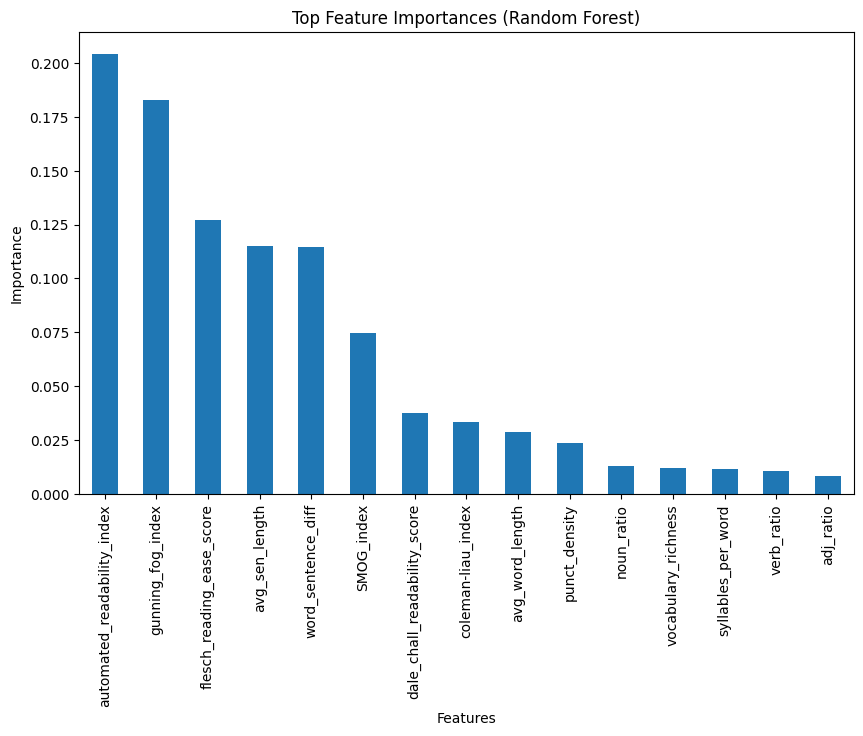

In [ ]:
# 4. Fit on full dataset and check feature importance
best_rf.fit(X, y)

importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances = importances.sort_values(ascending=False)

print("\n Top 10 Important Features:")
print(importances.head(10))

# Optional: Plot feature importance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
importances.head(15).plot(kind="bar")
plt.title("Top Feature Importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.show()

In [ ]:
grid_search.best_params_

{'max_depth': 30,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 300}

#Попробуем обучить с помощью градиентного бустинга

In [ ]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_test)

In [ ]:

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MAE: 0.3100093161941746
RMSE: 0.16846867635966206
R²: 0.8282184422156975


<h2>Попробуем выявить наилучшие параметры для модели</h2>

In [ ]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

In [ ]:
xgb_model = XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1
)

In [ ]:
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

In [ ]:
# Define grid search
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',     # or 'neg_mean_squared_error'
    cv=5,
    n_jobs=-1,
    verbose=1
)

In [ ]:
#  Fit
grid_search_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=-1, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.8, 1.0]},
             scoring='r2', verbose=1)

In [ ]:
# Show best results
print("Best parameters:", grid_search_xgb.best_params_)
print("Best R²:", grid_search_xgb.best_score_)


✅ Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
📈 Best R²: 0.8286689247176817


In [ ]:
# Use best model
best_xgb = grid_search_xgb.best_estimator_
y_pred = best_xgb.predict(X_test)

<h2>Сохраним наши модели с наилучшими параметрами</h2>

In [ ]:
import joblib

joblib.dump(model_rf, "random_forest_model.pkl")

['random_forest_model.pkl']

In [ ]:
model_xgb.save_model("xgboost_model.json")

Save & Load RandomForest (using joblib)

import joblib

Save

joblib.dump(rf_model, "random_forest_model.pkl")

Load

rf_loaded = joblib.load("random_forest_model.pkl")

Check

y_pred = rf_loaded.predict(X_test)


Save & Load XGBoost (two options)

joblib.dump(best_xgb, "xgboost_model.pkl")
xgb_loaded = joblib.load("xgboost_model.pkl")